In [1]:
# -*- coding: utf-8 -*-

In [2]:
import pandas as pd
import json
from scipy import stats
import numpy as np
import csv
import pprint
from collections import defaultdict

import math
import matplotlib.pyplot as plt; plt.rcdefaults()
from IPython.display import Markdown, display

import re
import os
import sys

import time
import datetime

In [3]:
csv.field_size_limit(sys.maxsize)

131072

In [4]:
USER_HISTORY_FOLDER = "/mnt/storage/quarantine/data/redpill_users_history"
RED_PILL_COMMENTS_FILE = "/mnt/storage/quarantine/data/theRedPillComments.csv"
PRE_QUARANTINE_USERS_FILE = "/mnt/storage/quarantine/data/preQuarantineUsers.csv"
TOXICITY_SCORES_FILE = "/mnt/storage/quarantine/data/theRedPillComments-toxicity.csv"

In [5]:
TIME_CHUNK_IN_DAYS = 10
QUARANTINE_DATE = "28/09/2018"

quarDataUnix = time.mktime(datetime.datetime.strptime(QUARANTINE_DATE, "%d/%m/%Y").timetuple())

In [6]:
def getTimeChunkIndex(timeStamp):
    timeStamp = float(timeStamp)
    timeDiff = timeStamp - quarDataUnix
    timeDiffDays = float(timeDiff)/(24*60*60) 
    chunkIndex = math.floor(timeDiffDays/TIME_CHUNK_IN_DAYS)
    return int(chunkIndex)

In [7]:
authorsInEachChunk = defaultdict(set)

In [8]:
with open(TOXICITY_SCORES_FILE) as csvfile:
    readCSV = csv.DictReader(csvfile)
    for row in readCSV:
        author = row['author']
        if (author != "[deleted]"):
            postTime = row['created_utc']
            timeChunkIndex = getTimeChunkIndex(postTime)
            authorsInEachChunk[timeChunkIndex].add(author)            

In [9]:
lists = sorted(authorsInEachChunk.items())

In [10]:
seenUsersSet = set()
for ulist in lists[0:3]:
    chunkUsers = ulist[1]
    seenUsersSet = seenUsersSet.union(chunkUsers)

In [11]:
newUsersSet = defaultdict(set)
for ulist in lists[4:]:
    chunkIndex = ulist[0]
    chunkUsers = ulist[1]
    newUsersSet[chunkIndex] = chunkUsers.difference(seenUsersSet)
    seenUsersSet = seenUsersSet.union(chunkUsers)

In [12]:
trp_toxicity_df = pd.read_csv(TOXICITY_SCORES_FILE)

TrpToxicityDistribution = defaultdict(list)
for i, row in trp_toxicity_df.iterrows():
    author = row['author']
    toxicity = row['toxicity']

    if (toxicity != -1):
        postTime = row['created_utc']
        timeChunkIndex = getTimeChunkIndex(postTime)
        if (author in newUsersSet[timeChunkIndex]):
            TrpToxicityDistribution[timeChunkIndex].append(toxicity)

TrpMeanToxicity = {}
for k in TrpToxicityDistribution:
    TrpMeanToxicity[k] = np.mean(TrpToxicityDistribution[k])

/nethome/sjhaver3/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


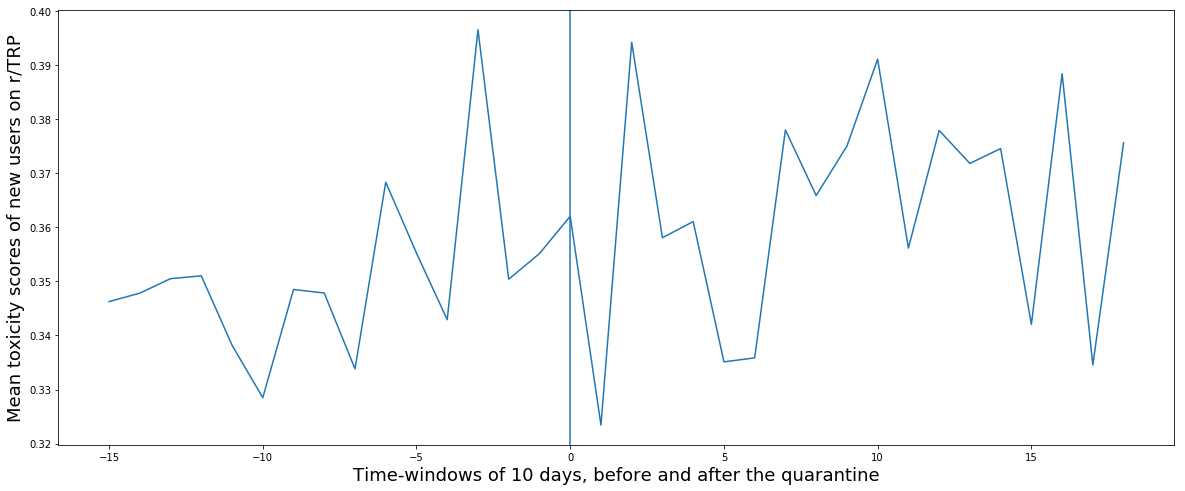

In [14]:
lists = sorted(TrpMeanToxicity.items())
x, y = zip(*lists)
plt.plot(x, y)
plt.axvline(x=0)
plt.rcParams["figure.figsize"] = (20,8)
plt.xlabel('Time-windows of 10 days, before and after the quarantine', fontsize=18)
plt.ylabel('Mean toxicity scores of new users on r/TRP', fontsize=18)
plt.show()

In [15]:
## Mean toxicity of new users does not seem to change post quarantining